In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.defences.trainer import AdversarialTrainer

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion, device):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

for epoch in range(1):
    train(model, train_loader, optimizer, criterion, device)

# Prepare test data
def gather_data(loader, device):
    x_data = []
    y_data = []
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        x_data.append(data.cpu().numpy())
        y_data.append(target.cpu().numpy())
    return np.concatenate(x_data, axis=0), np.concatenate(y_data, axis=0)

x_test, y_test = gather_data(test_loader, device)

# Wrap the PyTorch model with ART's PyTorchClassifier
classifier = PyTorchClassifier(model=model, 
                               loss=nn.CrossEntropyLoss(), 
                               optimizer=optimizer, 
                               input_shape=(1, 28, 28), 
                               nb_classes=10)

# Attack the model using Fast Gradient Method (FGM)
attack = FastGradientMethod(classifier, eps=1.5, eps_step=2)

# Generate adversarial samples
x_test_adv = attack.generate(x=x_test)

# Evaluate the model
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

def evaluate_adv(model, x_test_adv, y_test, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        x_test_adv_tensor = torch.tensor(x_test_adv, dtype=torch.float32).to(device)
        outputs = model(x_test_adv_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total += len(y_test)
        correct += (predicted.cpu().numpy() == y_test).sum()
    return correct / total

accuracy = evaluate(model, test_loader, device)
print(f'Accuracy without attack: {accuracy:.2f}')

accuracy_adv = evaluate_adv(classifier.model, x_test_adv, y_test, device)
print(f'Accuracy under attack with no protection: {accuracy_adv:.2f}')

Accuracy without attack: 0.95
Accuracy under attack with no protection: 0.02


In [86]:
# Convert tensors to NumPy arrays for AdversarialTrainer
x_test_np = x_test.astype(np.float32)
y_test_np = y_test.astype(np.int64)

# Add adversarial training
defence = AdversarialTrainer(classifier=classifier, attacks=attack)
defence.fit(x_test_np, y_test_np)

# Evaluate the model with adversarial training
accuracy_defended = evaluate_adv(classifier.model, x_test_adv, y_test, device)
print(f'Accuracy under attack with protection: {accuracy_defended:.2f}')

Adversarial training epochs: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]

Accuracy under attack with protection: 0.84


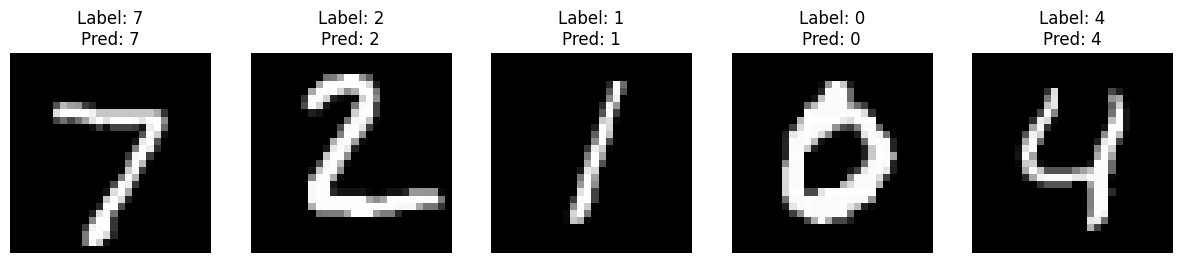

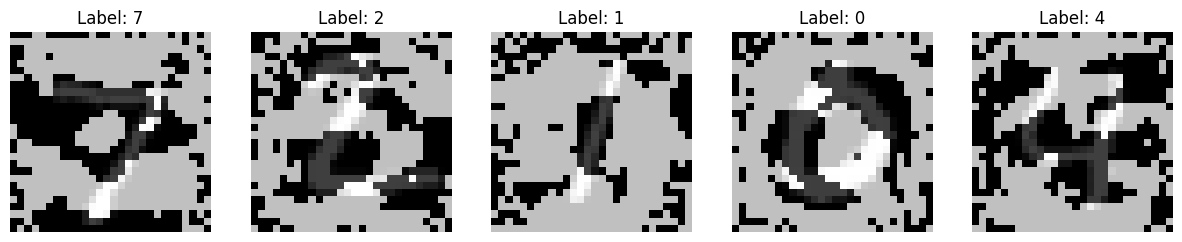

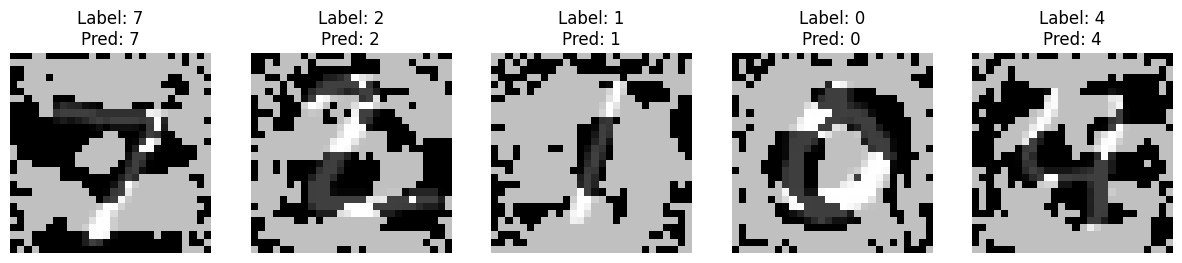

In [87]:
# Function to plot images and their labels
def plot_samples(images, labels, predictions=None, title="Images"):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i in range(len(images)):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        title_str = f'Label: {labels[i]}'
        if predictions is not None:
            title_str += f'\nPred: {predictions[i]}'
        axes[i].set_title(title_str)
        axes[i].axis('off')
    plt.show()

# Visualize original test images with model predictions
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
with torch.no_grad():
    predictions = torch.argmax(model(x_test_tensor).cpu(), dim=1).numpy()

plot_samples(x_test[:5], y_test[:5], predictions=predictions[:5], title="Original Test Images")

# Visualize adversarial examples with true labels
plot_samples(x_test_adv[:5], y_test[:5], title="Adversarial Examples")

# Evaluate adversarial examples with the model
with torch.no_grad():
    adv_predictions = torch.argmax(model(torch.tensor(x_test_adv, dtype=torch.float32).to(device)).cpu(), dim=1).numpy()

# Visualize adversarial examples with model predictions
plot_samples(x_test_adv[:5], y_test[:5], predictions=adv_predictions[:5], title="Adversarial Examples with Predictions")